Zachary Yore

# A5 Convolutional Neural Network (Total 150pts)


## 1. Import libraries (Total 6pts)

### 1.1 Import torch, torchvision, torchvision.transforms, torch.utils.data and torch.nn (6pts)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn

## 2. Data Preparation (Total 32pts)


### 2.1 Image Transformation (12pts)
Define a transformation pipeline using torchvision.transforms.Compose.

In the pipeline, use **ColorJitter, GaussianBlur, RandomHorizontalFlip, ToTensor and Normalize** from the transforms library.

For the first four transformations, use suitable parameters of your informed choice. At the end, normalize the images with mean 0.5 and variance 0.5.

Read about these transformations here: https://pytorch.org/vision/0.9/transforms.html

In [2]:
transform_pipeline = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### 2.2 Prepare train and test set by loading CIFAR10 dataset from torchvision.datasets. (4pts)
Make sure you are using the **transform** pipeline (you just wrote in task #2.1) on both train and test set. 

**Hint:** Preparing train and test sets can be directly achieved by utilizing the class parameters.


Read about CIFAR10 dataset class in PyTorch: https://pytorch.org/vision/0.9/datasets.html#cifar

In [3]:
import torchvision.datasets as datasets
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_pipeline)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_pipeline)

100%|██████████| 170498071/170498071 [00:05<00:00, 30913051.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.3 Use torch.utils.data.random_split() to make a validation set from the training set with 80:20 split. (3pts)

Make sure the training set you'll use after this point excludes the validation set of images 


In [4]:
from torch.utils.data import random_split
train_length = int(len(train_set) * 0.8)
validation_length = len(train_set) - train_length
train_set, validation_set = random_split(train_set, [train_length, validation_length])

### 2.4 Prepare three dataloaders for train, validation and test set. Use an appropriate batchsize of your choice. (1+2+2+2 =7pts)


**Hints:**
1. Remember that choosing a batchsize is always a trade-off between efficiency and generalizability. With large batchsize, your model learns more and better in each forward pass, but each pass will require larger computation. On the other hand, with small batchsize, it might converge quicker, but each forward pass teaches features from a smaller subset, which may not be a good representation of the overall data; leading to jittery convergence.
2. During training, you will use the train and validation set for tracking the loss and avoiding overfitting. The test set will be hold out until you are ready to evaluate a trained model on new data. 

Read about pytorch Dataloaders here:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

In [5]:
from torch.utils.data import DataLoader
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

### 2.5 Load a random batch of images from the training set using the trainloader. Then use *make_grid()*  from *torchvision.utils* and *imshow()* from *matplotlib.pyplot* to show the images. Also, print the corresponding true labels for those image samples. (6pts)
Hint: you may need to reshape the *make_grid()* output to comply with the format *imshow()* accepts.

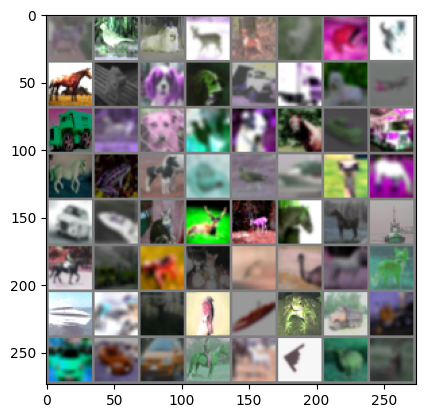

Ground truth labels: horse  bird   dog  deer   dog   dog  frog   cat horse   cat   dog   dog truck truck   dog airplane truck horse   dog   cat   dog horse automobile truck horse  frog horse  frog  bird  ship  bird horse automobile  ship   cat  deer  deer horse horse  ship horse truck  frog   cat  bird  bird horse   dog  ship automobile  deer  bird  ship  frog truck truck automobile automobile automobile horse horse airplane  deer  deer


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, labels = next(iter(train_loader))
grid = make_grid(images)
imshow(grid)
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Ground truth labels:', ' '.join('%5s' % cifar10_classes[labels[j]] for j in range(batch_size)))

## 3. Model Design (Total 22pts)

### 3.1 Define a neural network model: (2+7+7 =16pts)
- Name the model class with your first name
- In the following sequential order, the model should consist:

    (1) a 2D convolution layer with 6 filters, dimension of each filter is (5, 5), stride=1, no zero padding
    
    (2) a Max Pool layer with filter size (2, 2), stride=2
    
    (3) a 2D convolution layer with 16 filters, dimension of each filter is (5, 5), stride=1, no zero padding

    (4) a 2D Max Pool layer with filter size (2, 2), stride=2
    
    ~ a flatten layer ~

    (5) a Dense/Fully-connected layer with 120 neurons
    
    ~ a ReLU activation ~
    
    ~ a Dropout Layer ~

    (6) a Dense/Fully-connected layer with 80 neurons
    
    ~ a ReLU activation ~

    (7) a Dense/Fully-connected layer with 10 neurons

Note: 
1. Flatten, ReLU and Dropout are not really "layers". They are operations with specific purpose. But in model construction in pytorch, they are abstracted as layers.
    
    Flatten is used to convert the 4th layer output to a 1D tensor so that it can be passed through the next fully-connected layer. Since each forward pass takes a batch of data, use the *start_dim* parameter of *torch.flatten()* appropriately to keep the batch dimension intact.
    
    ReLU is an activation that transforms the Dense Layer's linear output to a non-linear "active" output.
    
    Dropout is a regularization technique. Read more in slides. In this assignment, you can drop neurons with 50% probability. 

2. This dataset has 10 classes, hence the final layer consists 10 neurons. 

3. The model architecture is similar to the one you saw in in-class Quiz 2, with an extra dense layer in the end. 

    Read about building your custom model in pytorch here: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

    The official pytorch documentation on conv, flatten, rely, dense are also resourceful.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Zachary(nn.Module):
    def __init__(self):
        super(Zachary, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.maxpool1(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool2(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
model = Zachary()


### 3.2 Create an instance of the model class that you just prepared. (2pts)

In [8]:
model = Zachary()
print(model)

Zachary(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


### 3.3 Set up Cross Entropy Loss as the loss function and *Adam* as the optimizer. Use a learning rate of your choice for the optimizer. (4pts) 


In [9]:
import torch.optim as optim
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 4. Training and Validation (Total 50pts)


### 4.1 Write a training loop to load data, compute model output, compute loss and backpropagating it to update model parameters. (30pts)

The # TODO tags below contain further instructions. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_model_state_dict = None
best_val_accuracy = 0

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    avg_train_loss = train_loss / (batch_idx + 1)
    avg_train_accuracy = 100.0 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    model.eval()

    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / (batch_idx + 1)
        avg_val_accuracy = 100.0 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_model_state_dict = model.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Acc: {avg_train_accuracy}, Val Loss: {avg_val_loss}, Val Acc: {avg_val_accuracy}")


Epoch 1/20, Train Loss: 2.0341215839385987, Train Acc: 25.345, Val Loss: 1.8516726744402745, Val Acc: 33.25
Epoch 2/20, Train Loss: 1.817423943901062, Train Acc: 34.35, Val Loss: 1.7237943532360587, Val Acc: 38.6
Epoch 3/20, Train Loss: 1.724602879333496, Train Acc: 37.92, Val Loss: 1.6233623103730996, Val Acc: 41.56
Epoch 4/20, Train Loss: 1.6670181476593018, Train Acc: 40.62, Val Loss: 1.574051392306188, Val Acc: 43.69
Epoch 5/20, Train Loss: 1.6164017385482787, Train Acc: 42.305, Val Loss: 1.5300875924954749, Val Acc: 45.27
Epoch 6/20, Train Loss: 1.5871309028625489, Train Acc: 43.4225, Val Loss: 1.506874029803428, Val Acc: 46.72
Epoch 7/20, Train Loss: 1.5530428064346313, Train Acc: 44.835, Val Loss: 1.4750252795067562, Val Acc: 47.63
Epoch 8/20, Train Loss: 1.5281245830535888, Train Acc: 45.7625, Val Loss: 1.4547810463389015, Val Acc: 48.48
Epoch 9/20, Train Loss: 1.4987209888458253, Train Acc: 46.7325, Val Loss: 1.4090563354978136, Val Acc: 50.7
Epoch 10/20, Train Loss: 1.4795523

### 4.2 Plot and compare (5+5 =10pts)
1. training and validation loss over the number of epochs
2. training and validation accuracy over the number of epochs

(Hint: Use plot() from *matplotlib.pyplot*, import it if you haven't already done so.)

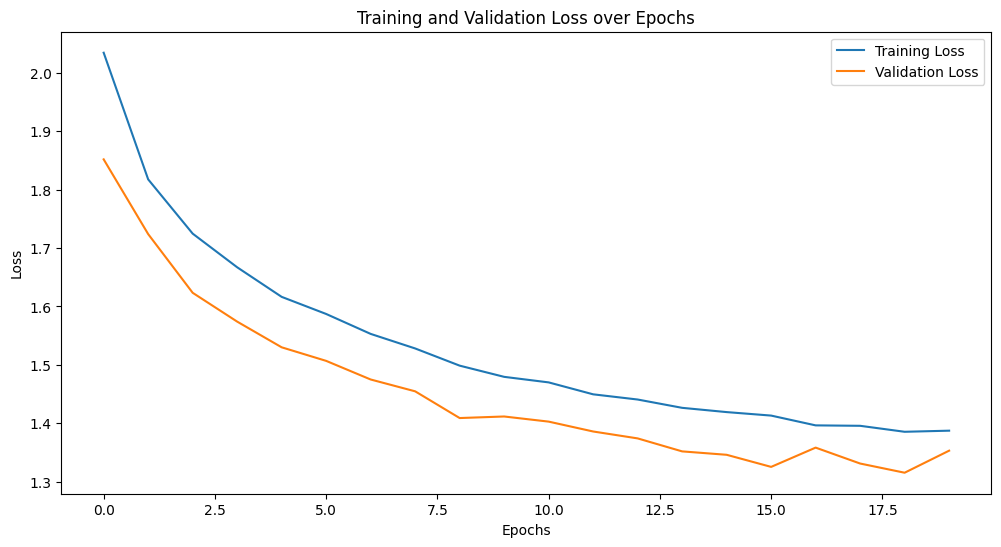

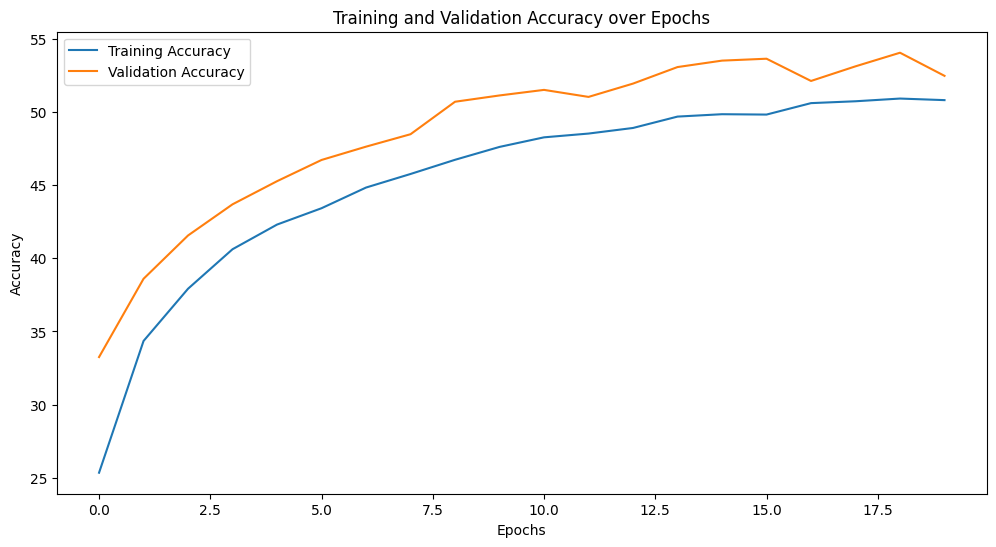

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), train_accuracies, label="Training Accuracy")
plt.plot(range(num_epochs), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

### 4.3 Discussion: (2*5 = 10pts)
(1) Does the training loss and accuracy improve as number of epoch increases?

(2) Does the validation loss and accuracy improve as number of epoch increases?

(3) Are there any sign of overfitting in the results? If so, when did it start to occur?

(4) How many epochs did it take for the model to converge to a good solution?

(5) What enhancement can be tried to the architecture to further improve the validation performance?

1). The training loss and accuracy do improve as the number of epochs increases. The training loss decreases and the accuracy increases throughout the 20 epochs.
2). The validation loss and accuracy also improve as the number of epochs increases. The validation loss decreases, and the accuracy increases over time.
3). There is a slight sign of overfitting as the training accuracy continues to increase while the validation accuracy stagnates or slightly fluctuates after around epoch 16.
4). The model seems to converge to a good solution around epoch 16. Where the validation accuracy is 53.64%. After that point the improvement in validation performance is minimal, and overfitting may begin.
5). Some enhancments that can be tried to the architecture to further the validation performance are use more advanced architectures like ResNet or DenseNet. Another option could be is to use learning rate scheduling. 

## 5. Testing on new data (Total 40pts)


### 5.1 Load the best performing model (one with good validation accuracy and without overfitting) among the ones you saved. (4pts)

In [12]:
best_model = Zachary().to(device)
best_model.load_state_dict(best_model_state_dict)
best_model.eval()

Zachary(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

### 5.2 Take a random batch of images from test set and show the images. Print the corresponding ground truth class labels. Then compute model output (model selected at previous step) and the predicted labels for the images in this batch. (10pts)

This is similar to task #2.5 with additional task on computing model output and printing predicted labels.

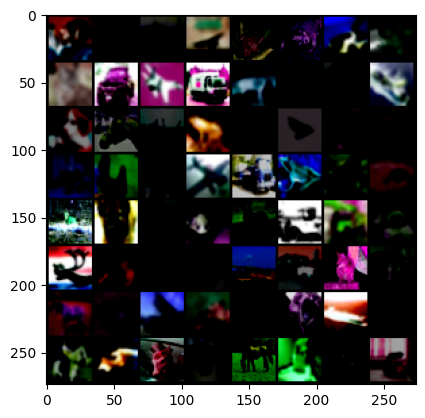

Ground truth labels: [3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3]
Predicted labels: [3, 8, 1, 8, 3, 6, 2, 6, 5, 1, 4, 9, 9, 7, 9, 6, 3, 4, 8, 7, 7, 0, 2, 1, 4, 3, 4, 0, 9, 6, 6, 4, 4, 6, 9, 3, 7, 1, 6, 8, 9, 4, 3, 6, 8, 9, 3, 5, 7, 2, 6, 8, 8, 6, 8, 8, 5, 8, 6, 4, 7, 3, 1, 0]


In [13]:
images, labels = next(iter(test_loader))
grid = make_grid(images)
grid_np = grid.numpy().transpose((1, 2, 0))
plt.imshow(grid_np)
plt.show()
print("Ground truth labels:", [label.item() for label in labels])
images = images.to(device)
with torch.no_grad():
    outputs = best_model(images)
_, predicted_labels = torch.max(outputs, 1)
print("Predicted labels:", [label.item() for label in predicted_labels])

### 5.3 Compute the average accuracy on test data using this model. (4+2 =6pts)
Loop over the test set, compute accuracy on each batch, lastly print the average accuracy. 

In [14]:
test_correct = 0
test_total = 0
best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted_labels = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted_labels == labels).sum().item()
avg_test_accuracy = 100.0 * test_correct / test_total
print("Average test accuracy: {:.2f}%".format(avg_test_accuracy))

Average test accuracy: 52.52%


### 5.4 Compute the average accuracy for each individual class. (8+4 =12pts)
Hint: similar to #5.3. During each loop, log the accuracy for each class separately (a python/numpy dictionary can help). Then print the individual accuracy for the 10 output classes. 

In [15]:
class_correct = [0.0 for _ in range(10)]
class_total = [0.0 for _ in range(10)]
best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted_labels = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i]
            pred_label = predicted_labels[i]
            class_total[label] += 1
            class_correct[label] += (pred_label == label).item()
for i in range(10):
    class_accuracy = 100.0 * class_correct[i] / class_total[i]
    print("Class {} accuracy: {:.2f}%".format(i, class_accuracy))

Class 0 accuracy: 53.60%
Class 1 accuracy: 69.70%
Class 2 accuracy: 36.40%
Class 3 accuracy: 26.90%
Class 4 accuracy: 46.10%
Class 5 accuracy: 43.50%
Class 6 accuracy: 65.30%
Class 7 accuracy: 59.80%
Class 8 accuracy: 73.90%
Class 9 accuracy: 50.20%


### 5.5 Discussion: (2+2+4 =8pts)
1. Which class of images were detected with highest accuracy? 
2. Which class of images were hardest for the model to detect? 
3. Explain 1-2 possible reasons why detection of some class can be harder for the same model. 

1). Class 8 of images was the easisest to detect with a accuracy score of 73.9.
2). Class 3 of images was the hardest to detect with a accuracy score of 26.9.
3). Some possible reasons for why detection of some classes can be harder for the model are a possible inbalence within the dataset and intra class verification. 